# Exercise 1 - Smoothing and Interpolation

## Introduction

These exercices present the implementation of smoothing and interpolating medical images using B-spline basis functions. These are techniques used in numerical analysis to approximate and refine data. Interpolating aims to construct a continuous function that exactly fits the available data points. The goal is to find a function that passes through or closely approximates these points so that we can estimate values between them. In this context, B-splines (Basis splines) provide a flexible way to build these functions, as they can accommodate different levels of smoothness and accuracy based on the spline order. In our examples, we explored how different B-spline orders (0, 1, and 3) affect the interpolation of a given set of data points, allowing us to visualize how increasing the order of the spline increases the smoothness of the resulting function.
<br>
<br>
Unlike interpolation, smoothing does not require the function to pass exactly through the data points. Instead, it constructs an approximation that "smooths out" the noise or variations in the data. This can be especially useful when dealing with noisy datasets where strict interpolation could overfit the data. In the exercises we performed, smoothing was perform in different scenarios, first in 1D signals, then 2D signals. For the second one smoothing matrix is going to be computed entirely and also by exploiting the separability of B-spline basis functions, which allowed us to apply the smoothing operation row-wise and then column-wise, simplifying the computational process. 


## Introduction
This exercise is about smoothing and interpolating medical images using B-spline basis functions. First, you will implement the principle on a one-dimensional signal, and then expand it to an image in 2D.

### Instructions for your report
Your report should be structured as follows:
* **Introduction**: a short summary of what your report is about, perhaps with a recap of some of the equations you'll be using in your solution.
* **Task 1, ..., 5**: for each specific task listed below, your code (in code cells), your results (as figures) as well as explanations of what is computed and what is shown in the figures (in Markdown cells). 
* **Conclusion**: a short summary of your findings.

This introduction should **not** be part of your report.

### Input data and dependencies
Import Python libraries

In [44]:
import numpy as np
import nibabel as nib
from matplotlib import pyplot as plt

np.set_printoptions( suppress=True )
plt.style.use('dark_background') # Dark theme
plt.ion()

Read a 3D image (an MRI scan of the brain) and extract the 2D slice you'll be working with in this exercise:

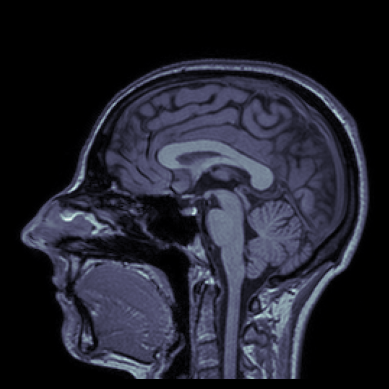

In [45]:
T1_file = './IXI002-Guys-0828-T1.nii.gz'
T1_nib = nib.load( T1_file )
data = T1_nib.get_fdata()

img = data[:, :, 75]
T = np.flipud( img.T )

plt.axis('off')
plt.imshow(T, cmap='bone');

Extract the 1D signal you'll be working with as the middle row of the 2D image

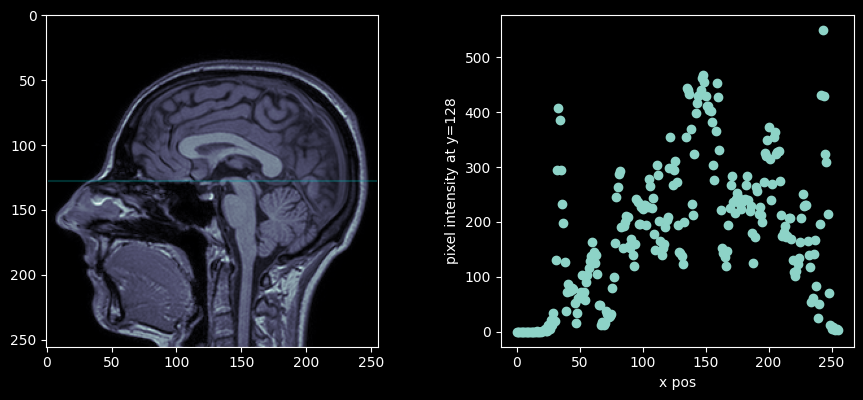

In [46]:
row = round( T.shape[0] / 2 )
t = T[row, :] #pixel intensity at row y = 128

N = t.shape[0]
x = np.arange(0, N)

# plot
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
fig.tight_layout(pad=5.0)

ax[0].imshow(T, cmap='bone')
ax[0].hlines(row, xmin=1, xmax=255, alpha=0.25, color='c')

ax[1].scatter(x, t)
ax[1].set_xlabel('x pos')
ax[1].set_ylabel('pixel intensity at y={}'.format(row))

plt.show();

---
## Task 1: B-splines basis functions
Implement a function that evaluates the uniform B-spline of orders 0, 1 and 3 at the locations provided in a vector $\mathbf{x}$. 

The function should return a vector $\mathbf{y}$ that is the same length as $\mathbf{x}$:

    def eval_BSpline(x, order=0):

        """
        Evaluates the uniform B-spline of order "order" at the locations in vector "x"
        """

        ...

        return y


Use this function to plot the uniform B-spline of orders 0, 1 and 3 at locations:  $\mathbf{x} = [-3.0,-2.99,-2.98, \ldots, 2.99,3.0]$

> ***Hint:*** use the function ```np.arange()``` to obtain $\mathbf{x}$.

In [47]:
def eval_BSpline(x, order=0):
    """
    Evaluates the uniform B-spline of order "order" at the locations in vector "x"
    """

    x = np.asarray(x)  # Ensure x is a NumPy array
    y = np.zeros_like(x)

    # given the order evaluate the uniform B-spline at the locations in x
    if order == 0:
        y[(x > -0.5) & (x < 0.5)] = 1
        y[(x == -0.5) | (x == 0.5)] = 0.5
        y[(x < -0.5) | (x > 0.5)] = 0
    elif order == 1:
        y[(x >= -1) & (x < 0)] = x[(x >= -1) & (x < 0)] + 1
        y[(x >= 0) & (x <= 1)] = 1 - x[(x >= 0) & (x <= 1)]
        y[(x < -1) | (x > 1)] = 0
    elif order == 3:
        abs_x = np.abs(x)
        
        # Different cases for cubic B-spline
        y[abs_x < 1] = (4 - 6 * abs_x[abs_x < 1]**2 + 3 * abs_x[abs_x < 1]**3) / 6.0
        y[(abs_x >= 1) & (abs_x < 2)] = (2 - abs_x[(abs_x >= 1) & (abs_x < 2)])**3 / 6.0
        y[abs_x >= 2] = 0
    else:
        raise ValueError('Order not implemented')

    return y

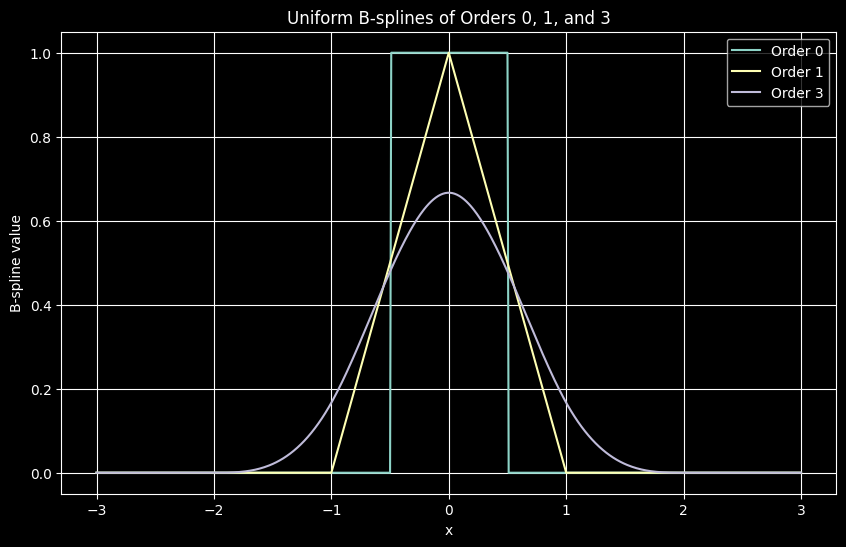

In [48]:
# Let's generate the axis
x = np.arange(-3.0, 3.01, 0.01)

# Generate a random verctor of length len(x) with integers from 0 to 3
v = np.random.randint(0, 50, len(x))

# Evaluate and plot the B-splines for orders 0, 1, and 3
plt.figure(figsize=(10, 6))

for order in [0, 1, 3]:
    y = eval_BSpline(x, order)
    plt.plot(x, y, label=f'Order {order}')

plt.title('Uniform B-splines of Orders 0, 1, and 3')
plt.xlabel('x')
plt.ylabel('B-spline value')
plt.legend()
plt.grid(True)
plt.show()

The respresentation of the B-splines are plotted above, as we can observe:
1. For order 0 we get a pulse centered in zero with a width of 1 and as we expected an amplitude of 1 in said width and zero everywhere else. It has very sharp transition.
2. For order 1 we get a triangale centered in zero with a width of 2 and an amplitude of 1. If we compare it to order 0, this function is smoother as the slope is less steep.
3. For order 3 we get a parabolic curve centered at zero. It is wider and smoother than those represented before and the tip looks round. 
<br>
<br>
With this we demonstrate that the higher the order of the B-splines, the smoother the approximations. 

---
## Task 2: Smoothing
Using the function you wrote above for evaluating a uniform B-spline of order 3, generate $M=6$ basis functions covering the entire domain $x=0,1,\ldots, 255$ of the 1D signal $\mathbf{t}$ defined in the introduction (which has length $N=256$). 

The basis functions should be scaled by a factor $h=(N-1)/(M-1)$, and shifted to be $h$ units apart (see book). 

Collect the obtained basis functions in a $N \times M$ matrix $\boldsymbol{\Phi}$, and plot them.

To shift it to be h units apart we just did : x - i * h: this is because to shift you have to substract by a factor of the number of the basis function times h. To scale it we divided by h as we want the 6 functions to fit in the limited space of x in (0,255). 
Once we got the stored matrix Phi by using the B_spline from task 1 , we plotted that. 

To get the smoothing matrix (S) we operated the Phi matrix as stated on the slides and using the hints given. 
The smoothed signal then is obtained by multiplying the smoothing matrix with the original signal (t).

51.0


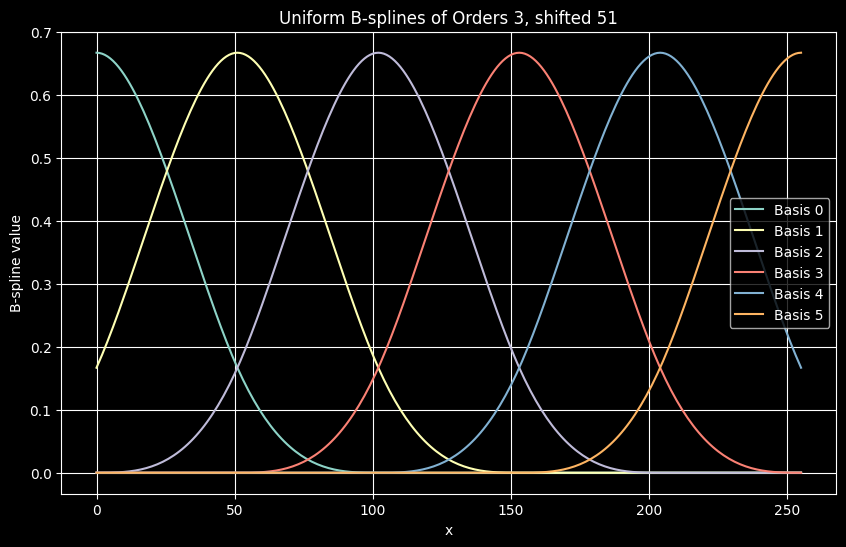

In [49]:
N = 256
M = 6
h = (N - 1) / ( M - 1 )
print(h)

# create an empty array of length 6
phi = np.zeros((N, M))

x = np.arange(N)

plt.figure(figsize=(10, 6))

for i in range(M):
    center = i * h
    shifted = (x - center) / h
    y = eval_BSpline(shifted, 3)
    phi[:, i] = y
    plt.plot(x, y, label=f'Basis {i}')

plt.title('Uniform B-splines of Orders 3, shifted 51')
plt.xlabel('x')
plt.ylabel('B-spline value')
plt.legend()
plt.grid(True)
plt.show()


Compute:
- the smoothing matrix: $\mathbf{S} = \boldsymbol{\Phi} (\boldsymbol{\Phi}^T \boldsymbol{\Phi})^{-1} \boldsymbol{\Phi}^T$
- the smoothed signal:  $\mathbf{\hat{t}} = \mathbf{S} \mathbf{t}$

Plots the results. Also plot the middle row of the smoothing matrix. 

>***Hint:*** 
>
> To compute the solution of a linear equation of the form Ax = b, you can use the following numpy function: ```np.linalg.solve(A, b)```. 
>
> You can also use the matrix inversion function ```np.linalg.inv()```, although this is numerically not the best solution.

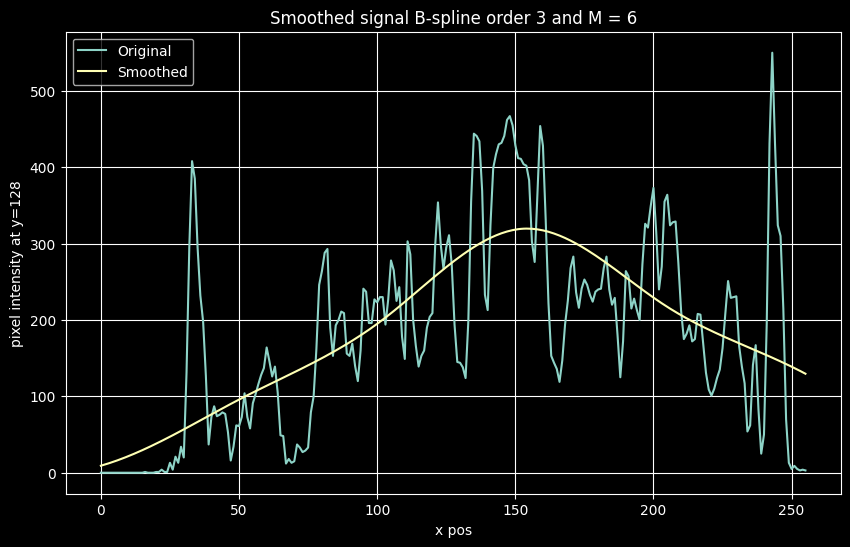

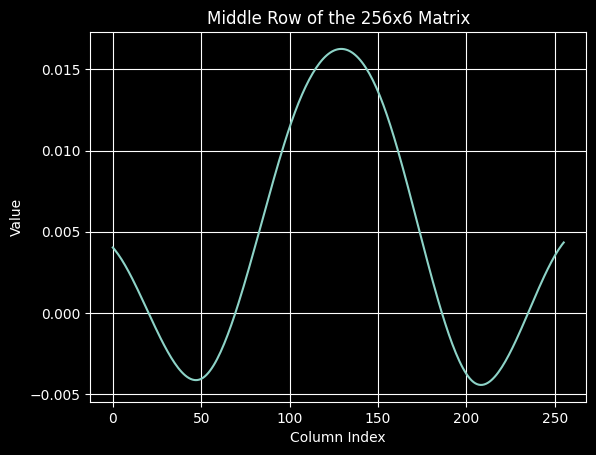

In [50]:
# compute the smoothing matrix
S = phi @ np.linalg.pinv(phi.T @ phi) @ phi.T

# apply the smoothing matrix to the image
T_smoothed = S @ t

# plot
plt.figure(figsize=(10, 6))
plt.title('Smoothed signal B-spline order 3 and M = 6')
plt.plot(x, t, label='Original')
plt.plot(x, T_smoothed, label='Smoothed')
plt.xlabel('x pos')
plt.ylabel('pixel intensity at y={}'.format(row))
plt.legend()
plt.grid(True)
plt.show()


middle_row_index = N // 2
middle_row = S[middle_row_index, :]

# Plot the middle row
plt.plot(middle_row)
plt.title(f'Middle Row of the {N}x{M} Matrix')
plt.xlabel('Column Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

Quick summary: To shift it to be h units apart we just did : x - i * h: this is because to shift you have to substract by a factor of the number of the basis function times h. To scale it we divided by h as we want the 6 functions to fit in the limited space of x in (0,255). Once we got the stored matrix Phi by using the B_spline from task 1 , we plotted that. To get the smoothing matrix (S) we operated the Phi matrix as stated on the slides and using the hints given. The smoothed signal then is obtained by multiplying the smoothing matrix with the original signal (t). 

Now repeat the same experiment when more basis functions are used: $M=16$ and $M=52$. 

> ***Q?:*** How does the smoothing behavior change? Explain.

In this task, we change the value of M to see the role it plays in the smoothing behaviour. At the begining the value is set to 6, therefore generating 6 basis functions, plotted above. If M is small, there are fewer basis functions to influence the spline, resulting in a stiffer spline. In this case, the spline tends to smooth out the data more aggressively, potentially ignoring finer details or "noise."
<br>
<br>
As M increases, as we can see when setting M to 16 and 52, more basis functions are added, which makes the spline more flexible. This allows the spline to better adapt to the variations in the data, sometimes even including noise. 
<br>
<br>
So overall, as the M value increases, the smoothed signal keeps more information from the original signal. 

17.0


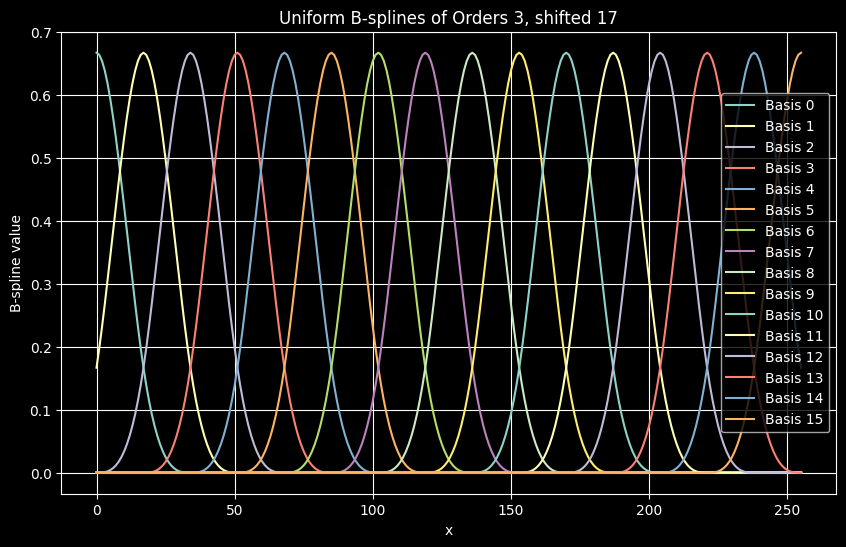

In [51]:
# M = 16
N = 256
M = 16
h = (N - 1) / ( M - 1 )
print(h)

# create an empty array of length 6
phi = np.zeros((N, M))

x = np.arange(N)

plt.figure(figsize=(10, 6))

for i in range(M):
    center = i * h
    shifted = (x - center) / h
    y = eval_BSpline(shifted, 3)
    phi[:, i] = y
    plt.plot(x, y, label=f'Basis {i}')

plt.title('Uniform B-splines of Orders 3, shifted 17')
plt.xlabel('x')
plt.ylabel('B-spline value')
plt.legend()
plt.grid(True)
plt.show()

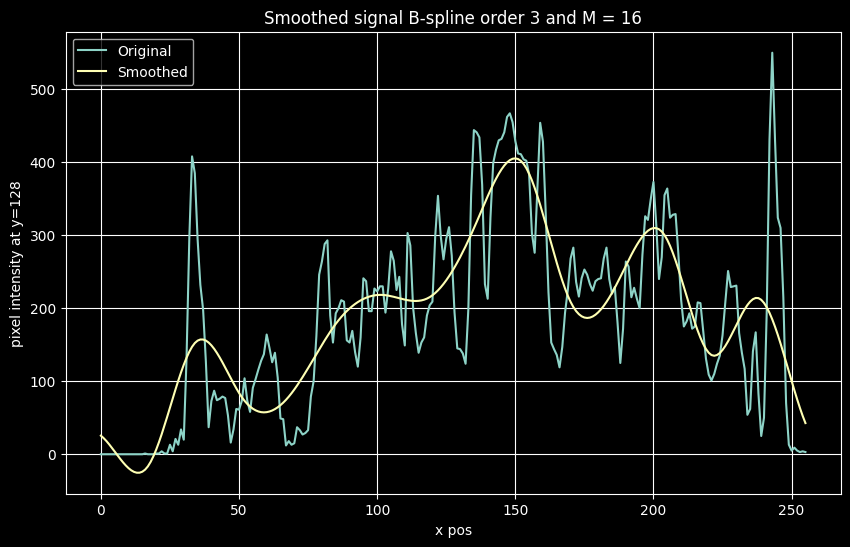

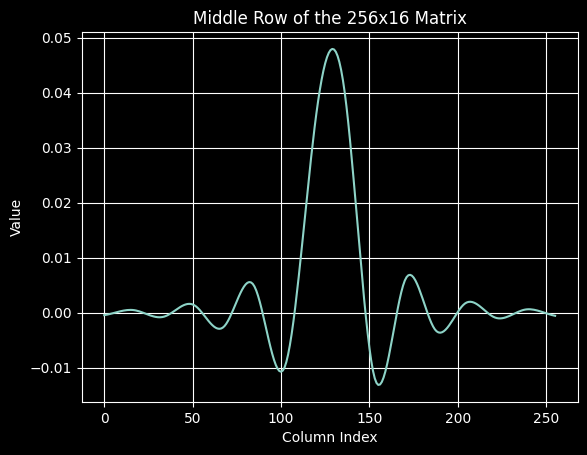

In [52]:
# compute the smoothing matrix
S = phi @ np.linalg.pinv(phi.T @ phi) @ phi.T

# apply the smoothing matrix to the image
T_smoothed = S @ t

# plot
plt.figure(figsize=(10, 6))
plt.title('Smoothed signal B-spline order 3 and M = 16')
plt.plot(x, t, label='Original')
plt.plot(x, T_smoothed, label='Smoothed')
plt.xlabel('x pos')
plt.ylabel('pixel intensity at y={}'.format(row))
plt.legend()
plt.grid(True)
plt.show()

middle_row_index = N // 2
middle_row = S[middle_row_index, :]

# Plot the middle row
plt.plot(middle_row)
plt.title(f'Middle Row of the {N}x{M} Matrix')
plt.xlabel('Column Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

5.0


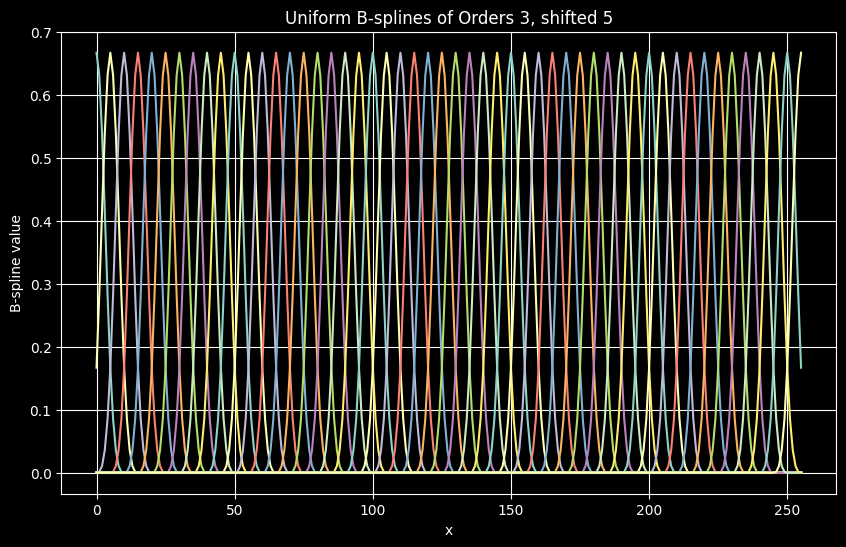

In [53]:
# M = 52
N = 256
M = 52
h = (N - 1) / ( M - 1 )
print(h)

# create an empty array of length 6
phi = np.zeros((N, M))

x = np.arange(N)

plt.figure(figsize=(10, 6))

for i in range(M):
    center = i * h
    shifted = (x - center) / h
    y = eval_BSpline(shifted, 3)
    phi[:, i] = y
    plt.plot(x, y, label=f'Basis {i}')

plt.title('Uniform B-splines of Orders 3, shifted 5')
plt.xlabel('x')
plt.ylabel('B-spline value')
plt.grid(True)
plt.show()

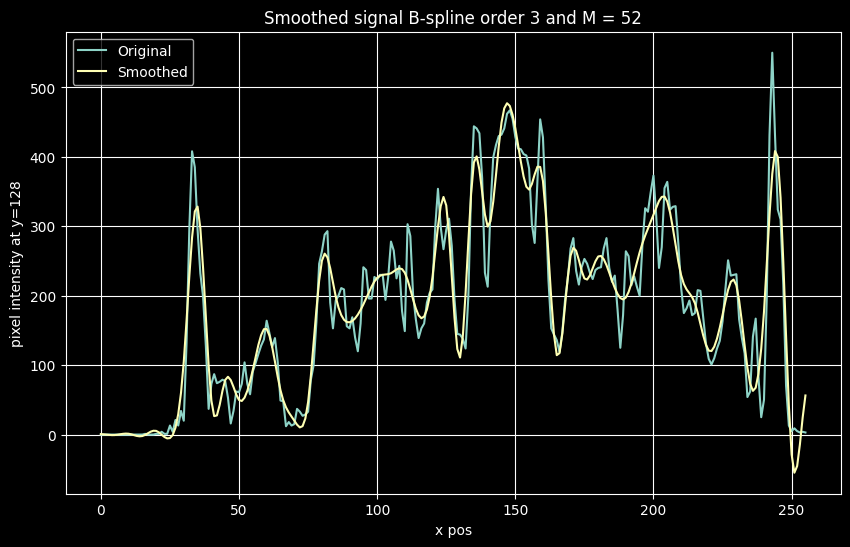

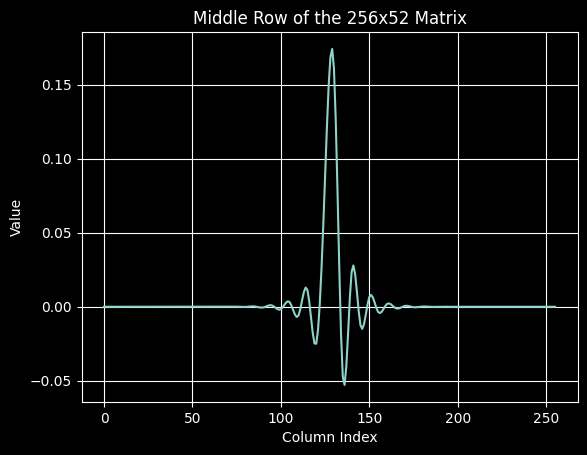

In [54]:
S = phi @ np.linalg.pinv(phi.T @ phi) @ phi.T

# apply the smoothing matrix to the image
T_smoothed = S @ t

# plot
plt.figure(figsize=(10, 6))
plt.title('Smoothed signal B-spline order 3 and M = 52')
plt.plot(x, t, label='Original')
plt.plot(x, T_smoothed, label='Smoothed')
plt.xlabel('x pos')
plt.ylabel('pixel intensity at y={}'.format(row))
plt.legend()
plt.grid(True)
plt.show()

middle_row_index = N // 2
middle_row = S[middle_row_index, :]

# Plot the middle row
plt.plot(middle_row)
plt.title(f'Middle Row of the {N}x{M} Matrix')
plt.xlabel('Column Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

---
## Task 3: Interpolation
Implement B-spline interpolation of the 1D signal $\mathbf{t}$, by evaluating the function $y( x, \mathbf{w})$ at locations $x = [120, 120.01, 120.02, \ldots 140]$

Show your results, along with the corresponding part of the signal $\mathbf{t}$, for three different orders of B-splines: 0, 1 and 3.

In the plot below, we can observe the original signal in red dot, then the following interpolated signals:
1. For order 0 or "nearest neighbor" represented in light green we get a signal that looks like steps with very sharp transitions between the data points
2. For order 1 or "linear interpolation" represented in light yellow connects the points with a line making it linear but not very smooth as it still has sharp edges
3. For order 3 or "cubic interpolation" represented in a light purple it is a  way smoother curve where we don't see any sharp transitions although it requires higher computation.

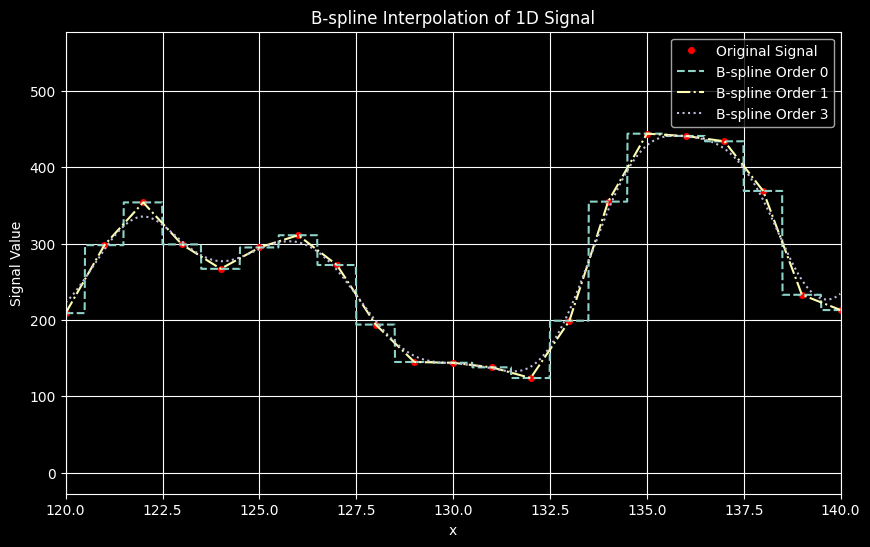

In [55]:
# implemente B-spline interpolation of signal t at locations x
x = np.arange(120, 140, 0.01)
x_t = np.arange(len(t))

def interpolate_signal(t_signal, x_signal, x_interp, order):
    y_interp = np.zeros_like(x_interp)
    
    # Handle order 0 separately (it only needs the nearest two points)
    if order == 0:
        for i, xi in enumerate(x_interp):
            idx = np.searchsorted(x_signal, xi) - 1
            if idx < 0 or idx >= len(x_signal) - 1:
                continue
            
            # Local coordinates for nearest two points
            local_x = x_signal[idx:idx + 2] - xi
            local_t = t_signal[idx:idx + 2]
            
            # Use eval_BSpline for order 0
            weights = eval_BSpline(local_x, order=order)
            y_interp[i] = np.dot(weights, local_t)
    
    # For orders 1 and 3, use neighborhood of size `order + 1`
    else:
        neighborhood_size = order + 1
        for i, xi in enumerate(x_interp):
            idx = np.searchsorted(x_signal, xi) - 1
            if idx < (neighborhood_size - 1) // 2 or idx >= len(x_signal) - (neighborhood_size // 2):
                continue

            # Define the local neighborhood of points
            local_indices = np.arange(idx - (neighborhood_size // 2), idx + (neighborhood_size // 2) + 1)
            local_x = x_signal[local_indices] - xi
            local_t = t_signal[local_indices]

            # Use eval_BSpline for higher orders
            weights = eval_BSpline(local_x, order=order)
            y_interp[i] = np.dot(weights, local_t)
    
    return y_interp


# Interpolate for B-spline orders 0, 1, and 3
y_interp_order0 = interpolate_signal(t, x_t, x, order=0)
y_interp_order1 = interpolate_signal(t, x_t, x, order=1)
y_interp_order3 = interpolate_signal(t, x_t, x, order=3)

# Plot the original signal and the interpolated signals
plt.figure(figsize=(10, 6))

# Plot original signal
plt.plot(x_t, t, label='Original Signal', color='red', linestyle='None', marker='o', markersize=4)

# Plot interpolated signals for different B-spline orders
plt.plot(x, y_interp_order0, label='B-spline Order 0', linestyle='--')
plt.plot(x, y_interp_order1, label='B-spline Order 1', linestyle='-.')
plt.plot(x, y_interp_order3, label='B-spline Order 3', linestyle=':')

# Set the x-axis limits to 120 and 140
plt.xlim(120, 140)

# Labels and legends
plt.title('B-spline Interpolation of 1D Signal')
plt.xlabel('x')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.show()


---
## Task 4: Smoothing in 2D
Now you are going to smooth the 2D image $\mathbf{T}$, which has dimensions $N_1 \times N_2 = 256 \times 256$, with $M_1=M_2=5$ B-spline-based 1D basis functions of order 3 for each direction.

Use the Kronecker product to produce a $N \times M$ matrix $\boldsymbol{\Phi} = \boldsymbol{\Phi}_2 \otimes \boldsymbol{\Phi}_1$, where:
- $N=N_1 N_2$ 
- $M = M_1 M_2$. 

Show a few 2D basis functions contained in the columns of $\boldsymbol{\Phi}$.

>***Hints***:
>* the Kronecker product of two matrices A and B can be calculated with ```np.kron(A, B)```
>* for converting a vectorized basis function ```v``` back into its 2D shape, use ```v.reshape(N_1, N_2, order='F')```
>* the following snippet can be used to show a 2D basis function:
>    ```
>        plt.figure(); 
>        ax = plt.axes(projection='3d'); 
>        ax.plot_wireframe(np.arange(N1).reshape(-1, 1), np.arange(N2).reshape(1, -1), basisFunction)
>
>    ```

Using cubic B splines makes sure the image is smooth in all directions with a shape looking like a bell that emphasizes certain points. We use the kronocker product to smooth everything evenly and to avoid computing a very big matrix. 

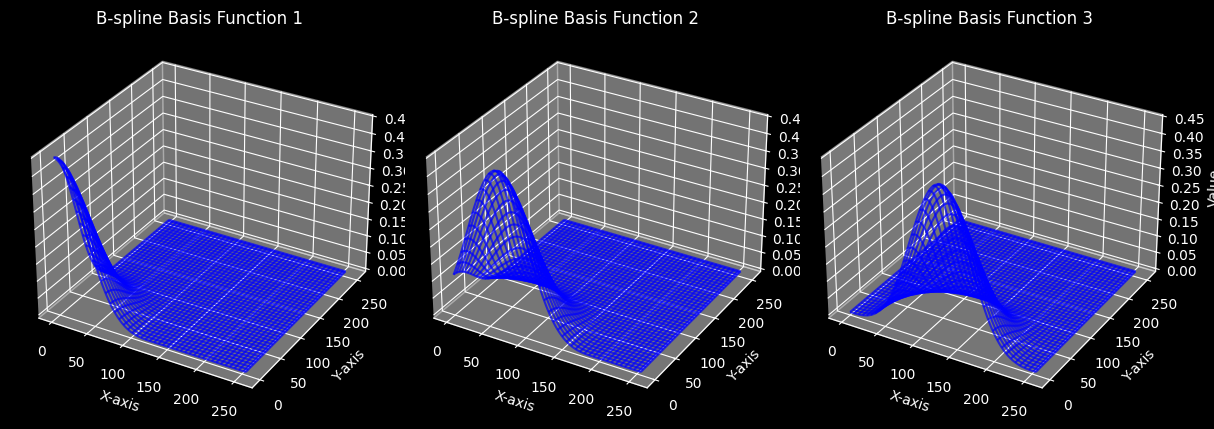

In [87]:
N_dim = 256
M_dim = 5

h1 = (N_dim - 1) / (M_dim - 1)

phi1 = np.zeros((N_dim, M_dim))
phi2 = np.zeros((N_dim, M_dim))

x = np.arange(N_dim)

for i in range(M_dim):
    centered = i * h1
    shifted = (x - centered) / h1
    phi1[:, i] = eval_BSpline(shifted, 3)
    phi2[:, i] = eval_BSpline(shifted, 3)

# Kronecker product to form the 2D basis functions
Phi = np.kron(phi2, phi1)  # (N1*N2) x (M1*M2)

# Plot a few selected 2D basis functions in 3D
num_to_plot = 3  # Number of basis functions to plot
fig = plt.figure(figsize=(12, 9))

for i in range(num_to_plot):
    ax = fig.add_subplot(1, num_to_plot, i + 1, projection='3d')  # Create subplots for each basis function

    basis_fn = Phi[:, i].reshape(N_dim, N_dim, order='F')  # Reshape each basis function

    # Create the wireframe plot for each basis function
    X = np.arange(N_dim).reshape(-1, 1)
    Y = np.arange(N_dim).reshape(1, -1)
    ax.plot_wireframe(X, Y, basis_fn, color='blue', alpha=0.7)

    ax.set_title(f'B-spline Basis Function {i + 1}')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Value')


plt.tight_layout()
plt.show()

Now:
- vectorize the 2D image $\mathbf{T}$ into a 1D signal $\mathbf{t}$
- smooth using $\boldsymbol{\Phi}$
- re-arrange the resulting 1D signal $\mathbf{\hat{t}}$ back into a 2D image $\mathbf{\hat{T}}$
- show the result.

>***Hints***: 
>* use ```T.reshape(-1, 1, order='F')``` and ```t.reshape(N_1, N_2, order='F')``` to vectorize and undo the vectorization.
>* do not explicitly compute the smoothing matrix $\mathbf{S}$ as it is very large!! Instead compute the weights $\mathbf{w} = (\boldsymbol{\Phi}^T \boldsymbol{\Phi})^{-1} \boldsymbol{\Phi}^T \mathbf{t}$ and expand those to get $\mathbf{\hat{t}} = \boldsymbol{\Phi} \mathbf{w}$.


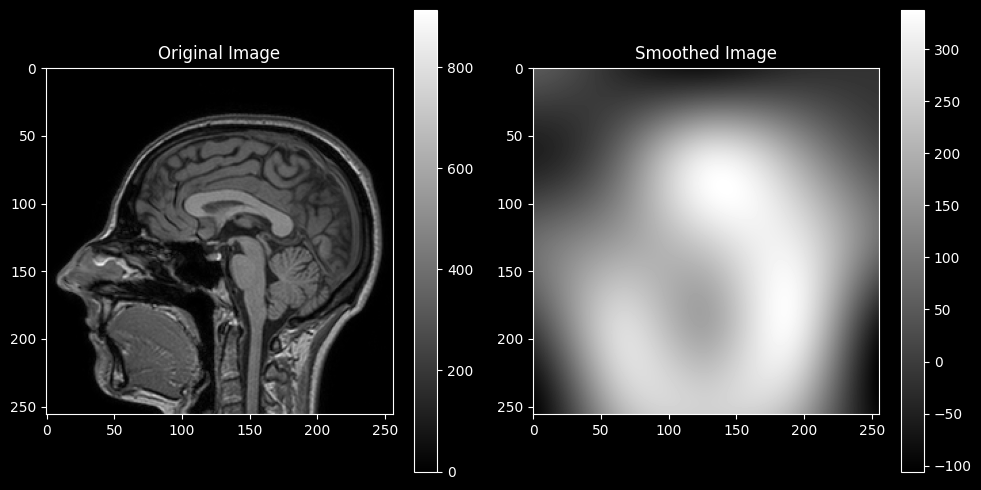

In [91]:
# Vectorize the 2D image into a 1D signal using column-major order ('F')
t_r = T.reshape(-1, 1, order='F')

# Compute the smoothing weights
Phi_inv = np.linalg.inv(Phi.T @ Phi)
Phi_inv_Phi_T = Phi_inv @ Phi.T 
w = Phi_inv_Phi_T @ t_r  # Smoothing weights

# Expand the weights to get the smoothed signal
hat_t = Phi @ w  # Smoothed 1D signal

# Re-arrange the smoothed 1D signal back into a 2D image
hat_T = hat_t.reshape(N_dim, N_dim, order='F')

# Show the original and smoothed images
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(T, cmap='gray')
plt.title('Original Image')
plt.colorbar()

# Smoothed image
plt.subplot(1, 2, 2)
plt.imshow(hat_T, cmap='gray')
plt.title('Smoothed Image')
plt.colorbar()

plt.tight_layout()
plt.show()

Also perform the same smoothing operation by exploiting the separability of the 2D basis functions, i.e, perform row-wise and then column-wise smoothing instead. 

Show the results, and verify that they are identical (use ```np.allclose()```) 

Are the results identical? True


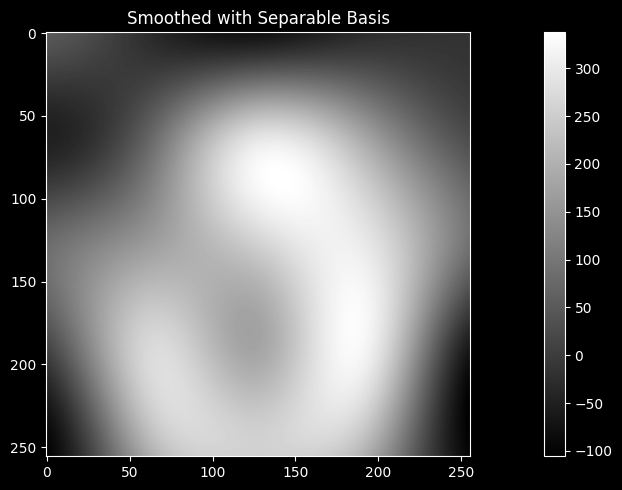

In [90]:
# Row-wise smoothing
Phi1_T_Phi1_inv = np.linalg.inv(phi1.T @ phi1)  # Invert for rows
w_rows = Phi1_T_Phi1_inv @ (phi1.T @ T)  # Apply row-wise smoothing
hat_T_rows = phi1 @ w_rows  # Smoothed rows

# Column-wise smoothing
Phi2_T_Phi2_inv = np.linalg.inv(phi2.T @ phi2)  # Invert for columns
w_cols = Phi2_T_Phi2_inv @ (phi2.T @ hat_T_rows.T)  # Apply column-wise smoothing on transposed data
hat_T_separable = (phi2 @ w_cols).T  # Transpose back to original orientation

# Compare the results
identical = np.allclose(hat_T, hat_T_separable)

print(f"Are the results identical? {identical}")

# Smoothed with separable approach
plt.figure(figsize=(15, 5))
plt.imshow(hat_T_separable, cmap='gray')
plt.title('Smoothed with Separable Basis')
plt.colorbar()

plt.tight_layout()
plt.show()

---
## Task 5: Interpolation in 2D
For B-spline order 0, 1 and 3, compute the weights $\mathbf{W}$ of the 2D interpolation model fitted to $\mathbf{T}$ by exploiting the separability of its basis functions.

Then show, as an image, interpolated function values $y( \mathbf{x}, \mathbf{w})$ for $\mathbf{x}=(x_1, x_2)^T$ with:
- $x_1=120.0, 120.1, 120.2 \ldots, 130.0$ 
- $x_2=120.0, 120.1, 120.2 \ldots, 130.0$ 

(101, 101) (101, 101) (101, 101)


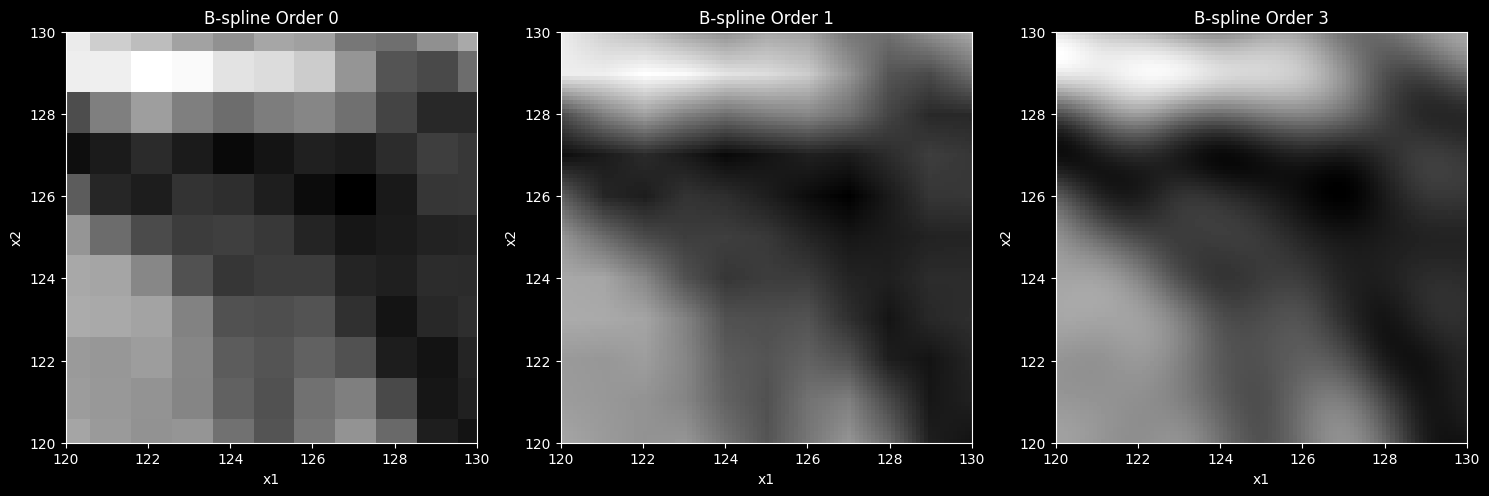

In [95]:
order_list = [0, 1, 3]  # Orders of B-spline to evaluate
x_1 = np.arange(120.0, 130.1, 0.1)  # Interpolation points from 120.0 to 130.0 with step 0.1
x_2 = np.arange(120.0, 130.1, 0.1)  # Interpolation points from 120.0 to 130.0 with step 0.1

M_1 = 256  # Number of basis functions in the first direction
M_2 = 256  # Number of basis functions in the second direction

N_1 = 256  # Number of points in the first direction
N_2 = 256  # Number of points in the second direction

h1 = (N_1 - 1) / (M_1 - 1)  # Step size for the first direction
h2 = (N_2 - 1) / (M_2 - 1)  # Step size for the second direction

phi1_0_interp = np.zeros((len(x_1), M_1))
phi1_1_interp = np.zeros((len(x_1), M_1))
phi1_3_interp = np.zeros((len(x_1), M_1))

phi2_0_interp = np.zeros((len(x_2), M_2))
phi2_1_interp = np.zeros((len(x_2), M_2))
phi2_3_interp = np.zeros((len(x_2), M_2))

for i in range(M_1):
    centered = i * h1
    shifted = (x_1 - centered) / h1
    phi1_0_interp[:, i] = eval_BSpline(shifted, 0)
    phi1_1_interp[:, i] = eval_BSpline(shifted, 1)
    phi1_3_interp[:, i] = eval_BSpline(shifted, 3)

for i in range(M_2):
    centered = i * h2
    shifted = (x_2 - centered) / h2
    phi2_0_interp[:, i] = eval_BSpline(shifted, 0)
    phi2_1_interp[:, i] = eval_BSpline(shifted, 1)
    phi2_3_interp[:, i] = eval_BSpline(shifted, 3)

# now the whole signal
phi1_0 = np.zeros((N_1, M_1))
phi1_1 = np.zeros((N_1, M_1))
phi1_3 = np.zeros((N_1, M_1))

phi2_0 = np.zeros((N_2, M_2))
phi2_1 = np.zeros((N_2, M_2))
phi2_3 = np.zeros((N_2, M_2))

for i in range(M_1):
    shifted = (np.arange(N_1) - i * h1) / h1
    phi1_0[:, i] = eval_BSpline(shifted, 0)
    phi1_1[:, i] = eval_BSpline(shifted, 1)
    phi1_3[:, i] = eval_BSpline(shifted, 3)

for i in range(M_2):
    shifted = (np.arange(N_2) - i * h2) / h2
    phi2_0[:, i] = eval_BSpline(shifted, 0)
    phi2_1[:, i] = eval_BSpline(shifted, 1)
    phi2_3[:, i] = eval_BSpline(shifted, 3)

# Compute the weights for each B-spline order
W_0 = np.linalg.pinv(phi1_0) @ T @ (np.linalg.pinv(phi2_0)).T
W_1 = np.linalg.inv(phi1_1) @ T @ np.linalg.inv(phi2_1.T @ phi2_1)
W_3 = np.linalg.inv(phi1_3.T @ phi1_3) @ phi1_3.T @ T @ phi2_3 @ np.linalg.inv(phi2_3.T @ phi2_3)

# Interpolate the image for each B-spline order
interp_0 = phi1_0_interp @ W_0 @ phi2_0_interp.T
interp_1 = phi1_1_interp @ W_1 @ phi2_1_interp.T
interp_3 = phi1_3_interp @ W_3 @ phi2_3_interp.T

print(interp_0.shape, interp_1.shape, interp_3.shape)

# Plot the interpolation results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the interpolated images
axs[0].imshow(interp_0, cmap='gray', extent=[120.0, 130.0, 120.0, 130.0], origin='lower')
axs[0].set_title('B-spline Order 0')
axs[0].set_xlabel('x1')
axs[0].set_ylabel('x2')

axs[1].imshow(interp_1, cmap='gray', extent=[120.0, 130.0, 120.0, 130.0], origin='lower')
axs[1].set_title('B-spline Order 1')
axs[1].set_xlabel('x1')
axs[1].set_ylabel('x2')

axs[2].imshow(interp_3, cmap='gray', extent=[120.0, 130.0, 120.0, 130.0], origin='lower')
axs[2].set_title('B-spline Order 3')
axs[2].set_xlabel('x1')
axs[2].set_ylabel('x2')

plt.tight_layout()
plt.show()

1. Order 0: We can see that the image looks pixelated in comparison to the other ones as it just assigns an approximation of the closest pixel and very drastic changes between adjacent points
2. Order 1: There is a better aproximation so it is much smoother but there are still some sharp changes
3. Order 3: has the smoothest transition and looks less pixalated as we are able to see more details.